In [1]:
%load_ext watermark
%watermark -a 'Niko' -v -p torch

Author: Niko

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.31.0

torch: 1.10.0



### Basic Graph Neural Network with Spectral Graph Convolution on MNIST

A very basic neural network (GNN) implementation using a spectral graph convolution.

<br>Here, the $28$ x $28$ image of a digit in MNIST represents the graph, where each pixel (i.e., cell in the grid) represents a particular node. The feature of that node is simply the pixel intensity in range $[0, 1]$.

<br>The adjacency matrix of the pixels is basically just determined by their neighborhood pixels. Using a Gaussian filter, we connect pixels based on their Euclidean distance in the grid.

<br>Using the adjacency matrix $A$ to compute the output of a layer as
\begin{align*}
X^{(l+1)} = AX^{(l)}W^{(l)}
\end{align*}

<br>Here, $A$ is the $N$ x $N$ adjacency matrix, and X is the $N$ x $C$ feature matrix (a 2D coordinate array, where $N$ is the total number of pixels -- $28$ x $28$ $=784$ in MNIST). $W$ is the weight matrix of shape $N$ x $P$, where $P$ would represent the number of classes if we have only a single hidden layer.

<br>In this notebook, we modify the code using spectral graph convolution, i.e.,

$$X^{(l+1)} = V\left(V^{T}X^{(l)} \odot V^{T}W_{\text {spectral}}^{(l)}\right)$$

<br>where $V$ are the eigen vectors of the graph Laplacian $L$, which we can compute the adjacency matrix $A$. Here, $W_{spectral}$ represents the trainable weights (filters).


In [2]:
# Import libraries
import time, torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.sparse.linalg import eigsh
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

%matplotlib inline

In [3]:
# Setting device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setting hyper-parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0005
NUM_EPOCHS = 20
BATCH_SIZE = 128
IMG_SIZE = 28

### MNIST Dataset

In [4]:
custom_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root="./data", train=True, transform=custom_transform, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False, transform=custom_transform, download=True)

In [5]:
SPLIT_ratio = 0.9 # 90% for training, 10% for valid
train_samples_num = int(len(train_dataset) * SPLIT_ratio)
val_samples_num = len(train_dataset) - train_samples_num

train_dataset, val_dataset = random_split(train_dataset, [train_samples_num, val_samples_num])

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
val_loader   = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)
test_loader  = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

# Check the dataset
for images, labels in train_loader:
    print('Image batch dimension: ', images.shape)
    print('Image label dimension: ', labels.shape)
    break

Image batch dimension:  torch.Size([128, 1, 28, 28])
Image label dimension:  torch.Size([128])


### Building Model

In [6]:
def precompute_adjacency_matrix(img_size):
    cols, rows = np.meshgrid(np.arange(img_size), np.arange(img_size))

    # N = img_size x img_size
    # Construct 2D coordinate array (shape N x 2) and normalize in range [0, 1]
    coord = np.stack((cols, rows), axis=2).reshape(-1, 2) / img_size

    # Compute pairwise distance matrix (N x N)
    dist = cdist(coord, coord, metric='euclidean')

    # Apply Gaussian filter
    sigma = 0.05 * np.pi
    A = np.exp(-dist / sigma**2)
    A[A < 0.01] = 0
    A = torch.from_numpy(A).float()

    # # Normalization as per (Kipf & Welling, ICLR 2017)
    # D = A.sum(1)  # node degree (N,)
    # D_hat = (D + 1e-5)**(-0.5)
    # A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1) # N, N

    return A

def get_graph_laplacian(A):
    # From https://towardsdatascience.com/spectral-graph-convolution-
    #   explained-and-implemented-step-by-step-2e495b57f801
    
    # Computing the graph Laplacian
    # A is an adjacency matrix of some graph G
    N = A.shape[0] # number vectorsof nodes in a graph
    D = np.sum(A, 0) # node degrees
    D_hat = np.diag((D + 1e-5)**(-0.5)) # normalized node degrees
    L = np.identity(N) - np.dot(D_hat, A).dot(D_hat) # Laplacian
    return torch.from_numpy(L).float()

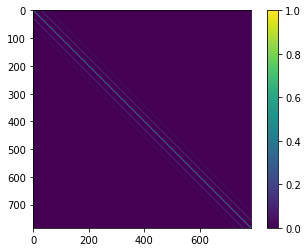

In [7]:
A = precompute_adjacency_matrix(28)
plt.imshow(A, vmin=0, vmax=1.)
plt.colorbar()
plt.show()

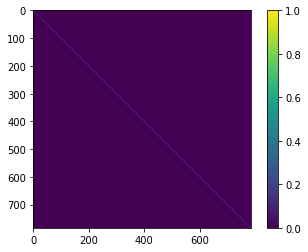

In [8]:
L = get_graph_laplacian(A.numpy())
plt.imshow(L, vmin=0., vmax=1.)
plt.colorbar()
plt.show()

In [9]:
class GraphNet(nn.Module):
    def __init__(self, img_size=28, num_filters=2, num_classes=10):
        super(GraphNet, self).__init__()

        n_rows = img_size**2
        self.fc = nn.Linear(n_rows*num_filters, num_classes, bias=False)

        A = precompute_adjacency_matrix(img_size)  # 784x784
        L = get_graph_laplacian(A.numpy()) # 784x784
        
        values, vectors = eigsh(L.numpy(), k=20, which='SM') # eigen-decomposition

        vectors = torch.from_numpy(vectors)  # 784x20

        # Weight matrix
        W_spectral = nn.Parameter(torch.ones((img_size**2, num_filters))).float() # 784x2
        torch.nn.init.kaiming_uniform_(W_spectral)

        self.register_buffer('A', A)
        self.register_buffer('L', L)
        self.register_buffer('vectors', vectors)
        self.register_buffer('W_spectral', W_spectral)

    def forward(self, x): # [B, 1, 28, 28]
        B = x.size(0) # Batch size

        # Reshape eigenvectors
        # from [H*W, 20] to [B, H*W, 20]
        vectors_tensor = self.vectors.unsqueeze(0)
        vectors_tensor = self.vectors.expand(B, -1, -1)
        # from [H*W, 20] to [B, 20, H*W]
        vectors_tensor_T = self.vectors.T.unsqueeze(0)
        vectors_tensor_T = vectors_tensor_T.expand(B, -1, -1)

        # Reshape inputs
        # [B, C, H, W] -> [B, H*W, 1]
        x_reshape = x.view(B, -1, 1)

        # Reshape spectral weights to size [128, H*W, F]
        W_spectral_tensor = self.W_spectral.unsqueeze(0)
        W_spectral_tensor = self.W_spectral.expand(B, -1, -1) # [128x784x2]

        # Spectral convolution on graphs
        # [B, 20, H*W] . [B, H*W, 1] -> [B, 20, 1]
        X_hat = vectors_tensor_T.bmm(x_reshape) # 20x1 node features in the "spectral" domain
        W_hat = vectors_tensor_T.bmm(W_spectral_tensor) # 20xF filters in the "spectral" domain
        
        Y = vectors_tensor.bmm(X_hat * W_hat) # NxF result of convolution

        # Fully connected
        logits = self.fc(Y.reshape(B, -1))
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [10]:
torch.manual_seed(RANDOM_SEED)
model = GraphNet(img_size=IMG_SIZE, num_filters=2, num_classes=10)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())

In [11]:
def compute_acc(model, dataloader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in dataloader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, pred_labels = torch.max(probas, 1)
        num_examples += features.size(0)
        correct_pred += (pred_labels == targets).sum()
    return correct_pred.float() / num_examples * 100

In [12]:
start_time = time.time()

loss_list = []
train_acc_list, val_acc_list, test_acc_list = [], [], []

for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        # Forward and back-propagation
        logits, probas = model(features)
        loss = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        loss.backward()
        # Update model parameters
        optimizer.step()
        loss_list.append(loss.item())

        if not batch_idx % 150:
            print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} |"
                    f"Batch: {batch_idx:03d}/{len(train_loader):03d} |"
                    f"Loss: {loss:.4f}")
    model.eval()
    with torch.no_grad():
        train_acc = compute_acc(model, train_loader, DEVICE)
        val_acc   = compute_acc(model, val_loader, DEVICE)
        test_acc  = compute_acc(model, test_loader, DEVICE)

        print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n"
                f"Train Accuracy: {train_acc:.2f} | Valid Accuracy: {val_acc:.2f} | Test Accuracy: {test_acc:.2f}")

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        test_acc_list.append(test_acc)

    elapsed = (time.time() - start_time) / 60
    print(f"Time elapsed: {elapsed:.2f} min")

elapsed = (time.time() - start_time) / 60
print(f"Total Training Time: {elapsed:.2f} min")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 001/020 |Batch: 000/422 |Loss: 2.3100
Epoch: 001/020 |Batch: 150/422 |Loss: 0.7928
Epoch: 001/020 |Batch: 300/422 |Loss: 0.8294


  5%|▌         | 1/20 [00:04<01:20,  4.24s/it]

Epoch: 001/020
Train Accuracy: 80.20 | Valid Accuracy: 80.85 | Test Accuracy: 81.21
Time elapsed: 0.07 min
Epoch: 002/020 |Batch: 000/422 |Loss: 0.5854
Epoch: 002/020 |Batch: 150/422 |Loss: 0.6880
Epoch: 002/020 |Batch: 300/422 |Loss: 0.6603


 10%|█         | 2/20 [00:08<01:16,  4.28s/it]

Epoch: 002/020
Train Accuracy: 81.59 | Valid Accuracy: 81.90 | Test Accuracy: 82.55
Time elapsed: 0.14 min
Epoch: 003/020 |Batch: 000/422 |Loss: 0.6439
Epoch: 003/020 |Batch: 150/422 |Loss: 0.4738
Epoch: 003/020 |Batch: 300/422 |Loss: 0.4903


 15%|█▌        | 3/20 [00:12<01:12,  4.25s/it]

Epoch: 003/020
Train Accuracy: 82.45 | Valid Accuracy: 82.88 | Test Accuracy: 83.31
Time elapsed: 0.21 min
Epoch: 004/020 |Batch: 000/422 |Loss: 0.7297
Epoch: 004/020 |Batch: 150/422 |Loss: 0.5638
Epoch: 004/020 |Batch: 300/422 |Loss: 0.4542


 20%|██        | 4/20 [00:17<01:08,  4.27s/it]

Epoch: 004/020
Train Accuracy: 82.85 | Valid Accuracy: 83.38 | Test Accuracy: 83.73
Time elapsed: 0.28 min
Epoch: 005/020 |Batch: 000/422 |Loss: 0.6803
Epoch: 005/020 |Batch: 150/422 |Loss: 0.4621
Epoch: 005/020 |Batch: 300/422 |Loss: 0.5559


 25%|██▌       | 5/20 [00:21<01:03,  4.24s/it]

Epoch: 005/020
Train Accuracy: 83.09 | Valid Accuracy: 83.43 | Test Accuracy: 84.03
Time elapsed: 0.35 min
Epoch: 006/020 |Batch: 000/422 |Loss: 0.5855
Epoch: 006/020 |Batch: 150/422 |Loss: 0.5492
Epoch: 006/020 |Batch: 300/422 |Loss: 0.5100


 30%|███       | 6/20 [00:25<00:58,  4.15s/it]

Epoch: 006/020
Train Accuracy: 83.59 | Valid Accuracy: 83.78 | Test Accuracy: 83.97
Time elapsed: 0.42 min
Epoch: 007/020 |Batch: 000/422 |Loss: 0.5451
Epoch: 007/020 |Batch: 150/422 |Loss: 0.5796
Epoch: 007/020 |Batch: 300/422 |Loss: 0.6270


 35%|███▌      | 7/20 [00:29<00:56,  4.34s/it]

Epoch: 007/020
Train Accuracy: 83.55 | Valid Accuracy: 84.07 | Test Accuracy: 84.09
Time elapsed: 0.50 min
Epoch: 008/020 |Batch: 000/422 |Loss: 0.5408
Epoch: 008/020 |Batch: 150/422 |Loss: 0.5836
Epoch: 008/020 |Batch: 300/422 |Loss: 0.5985


 40%|████      | 8/20 [00:34<00:51,  4.33s/it]

Epoch: 008/020
Train Accuracy: 84.06 | Valid Accuracy: 84.50 | Test Accuracy: 84.85
Time elapsed: 0.57 min
Epoch: 009/020 |Batch: 000/422 |Loss: 0.5479
Epoch: 009/020 |Batch: 150/422 |Loss: 0.5470
Epoch: 009/020 |Batch: 300/422 |Loss: 0.4560


 45%|████▌     | 9/20 [00:38<00:47,  4.30s/it]

Epoch: 009/020
Train Accuracy: 84.27 | Valid Accuracy: 84.40 | Test Accuracy: 85.03
Time elapsed: 0.64 min
Epoch: 010/020 |Batch: 000/422 |Loss: 0.5787
Epoch: 010/020 |Batch: 150/422 |Loss: 0.4212
Epoch: 010/020 |Batch: 300/422 |Loss: 0.4987


 50%|█████     | 10/20 [00:42<00:42,  4.30s/it]

Epoch: 010/020
Train Accuracy: 83.98 | Valid Accuracy: 84.60 | Test Accuracy: 84.74
Time elapsed: 0.71 min
Epoch: 011/020 |Batch: 000/422 |Loss: 0.6031
Epoch: 011/020 |Batch: 150/422 |Loss: 0.4983
Epoch: 011/020 |Batch: 300/422 |Loss: 0.4981


 55%|█████▌    | 11/20 [00:46<00:38,  4.24s/it]

Epoch: 011/020
Train Accuracy: 84.18 | Valid Accuracy: 84.78 | Test Accuracy: 85.03
Time elapsed: 0.78 min
Epoch: 012/020 |Batch: 000/422 |Loss: 0.3882
Epoch: 012/020 |Batch: 150/422 |Loss: 0.5513
Epoch: 012/020 |Batch: 300/422 |Loss: 0.5156


 60%|██████    | 12/20 [00:51<00:33,  4.20s/it]

Epoch: 012/020
Train Accuracy: 84.33 | Valid Accuracy: 84.98 | Test Accuracy: 84.99
Time elapsed: 0.85 min
Epoch: 013/020 |Batch: 000/422 |Loss: 0.5544
Epoch: 013/020 |Batch: 150/422 |Loss: 0.5681
Epoch: 013/020 |Batch: 300/422 |Loss: 0.5028


 65%|██████▌   | 13/20 [00:55<00:29,  4.21s/it]

Epoch: 013/020
Train Accuracy: 84.43 | Valid Accuracy: 84.82 | Test Accuracy: 84.86
Time elapsed: 0.92 min
Epoch: 014/020 |Batch: 000/422 |Loss: 0.4337
Epoch: 014/020 |Batch: 150/422 |Loss: 0.5530
Epoch: 014/020 |Batch: 300/422 |Loss: 0.4411


 70%|███████   | 14/20 [00:59<00:25,  4.17s/it]

Epoch: 014/020
Train Accuracy: 84.23 | Valid Accuracy: 84.25 | Test Accuracy: 84.85
Time elapsed: 0.99 min
Epoch: 015/020 |Batch: 000/422 |Loss: 0.8082
Epoch: 015/020 |Batch: 150/422 |Loss: 0.5892
Epoch: 015/020 |Batch: 300/422 |Loss: 0.4848


 75%|███████▌  | 15/20 [01:03<00:20,  4.18s/it]

Epoch: 015/020
Train Accuracy: 84.71 | Valid Accuracy: 84.98 | Test Accuracy: 85.19
Time elapsed: 1.06 min
Epoch: 016/020 |Batch: 000/422 |Loss: 0.4673
Epoch: 016/020 |Batch: 150/422 |Loss: 0.5016
Epoch: 016/020 |Batch: 300/422 |Loss: 0.5323


 80%|████████  | 16/20 [01:07<00:16,  4.18s/it]

Epoch: 016/020
Train Accuracy: 84.71 | Valid Accuracy: 84.82 | Test Accuracy: 85.43
Time elapsed: 1.13 min
Epoch: 017/020 |Batch: 000/422 |Loss: 0.5916
Epoch: 017/020 |Batch: 150/422 |Loss: 0.4727
Epoch: 017/020 |Batch: 300/422 |Loss: 0.4708


 85%|████████▌ | 17/20 [01:11<00:12,  4.19s/it]

Epoch: 017/020
Train Accuracy: 84.72 | Valid Accuracy: 85.10 | Test Accuracy: 85.46
Time elapsed: 1.20 min
Epoch: 018/020 |Batch: 000/422 |Loss: 0.5350
Epoch: 018/020 |Batch: 150/422 |Loss: 0.4969
Epoch: 018/020 |Batch: 300/422 |Loss: 0.6034


 90%|█████████ | 18/20 [01:15<00:08,  4.15s/it]

Epoch: 018/020
Train Accuracy: 84.89 | Valid Accuracy: 85.23 | Test Accuracy: 85.52
Time elapsed: 1.27 min
Epoch: 019/020 |Batch: 000/422 |Loss: 0.5947
Epoch: 019/020 |Batch: 150/422 |Loss: 0.4334
Epoch: 019/020 |Batch: 300/422 |Loss: 0.5289


 95%|█████████▌| 19/20 [01:19<00:04,  4.05s/it]

Epoch: 019/020
Train Accuracy: 84.52 | Valid Accuracy: 84.97 | Test Accuracy: 85.23
Time elapsed: 1.33 min
Epoch: 020/020 |Batch: 000/422 |Loss: 0.4829
Epoch: 020/020 |Batch: 150/422 |Loss: 0.5159
Epoch: 020/020 |Batch: 300/422 |Loss: 0.4671


100%|██████████| 20/20 [01:23<00:00,  4.18s/it]

Epoch: 020/020
Train Accuracy: 84.54 | Valid Accuracy: 84.58 | Test Accuracy: 85.23
Time elapsed: 1.39 min
Total Training Time: 1.39 min


### Evaluation

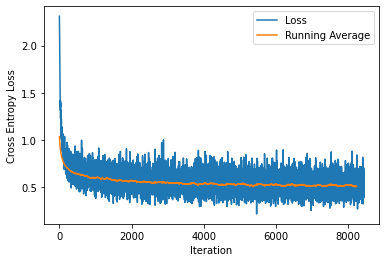

In [13]:
plt.plot(loss_list, label='Loss')
plt.plot(np.convolve(loss_list, np.ones(200,) / 200, mode='valid'), label='Running Average')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

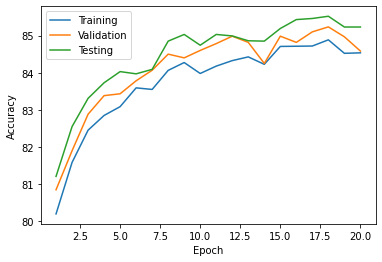

In [14]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), val_acc_list, label='Validation')
plt.plot(np.arange(1, NUM_EPOCHS+1), test_acc_list, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()